In [44]:
import os
import os.path as ospath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import glob
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

from picasso.picasso import io


In [45]:
def load_ring_data_df(dirname, filename):
    file = ospath.join(dirname, filename)

    try: 
        df = pd.read_pickle(file)
    except FileNotFoundError:
        print("No results of previously analyzed datasets were detected.")
        return None
    else: 
        print("Results of previously analyzed datasets were detected.")
        return df
    
def load_data(path):

    try:
        locs, info = io.load_locs(path)
    except io.NoMetadataFileError:
        return None, None, None
    
    try:
        pixelsize = info[1]["Pixelsize"]
    except:  
        print("No pixelsize found in yaml file. Default 130 nm used.")

        
    return locs, info, pixelsize

In [46]:
path = r'W:\users\reinhardt\z.software\Git\spor-PAINT\dev_sr\spor-paint\FtsZ\FtsZ_picks_all'

dR = 100

df_ring_data = load_ring_data_df(path, "ring_data_filter.pkl")

Results of previously analyzed datasets were detected.


In [91]:
# https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines
# https://github.com/madrury/basis-expansions/blob/master/LICENSE
"""
BSD 3-Clause License

Copyright (c) 2017, Matthew Drury
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE."""


import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

fov_1_veg_pick_0_ring_0_rot_xy_update.hdf5
angle -179.84878540039062 179.75424194335938
[[-200.03038    -213.7491     -184.92099    ... -227.88583
  -190.09286    -178.54208   ]
 [  -0.52787495   -0.6870501    -1.1801635  ...    1.4197536
     0.96343964    0.7657829 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F133C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7D9C808>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


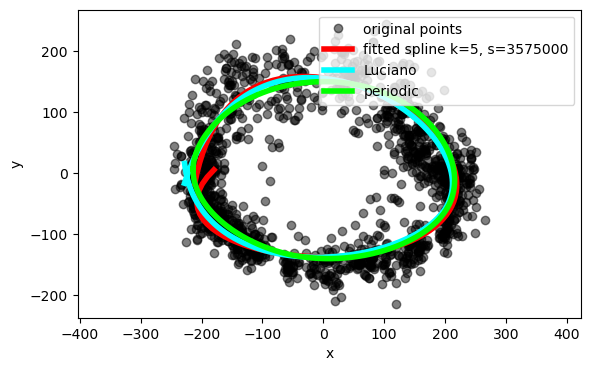

fov_1_veg_pick_1_ring_0_rot_xy_update.hdf5
angle -179.03358459472656 179.7515411376953
[[-104.46896    -24.074432   -63.4885    ... -123.13693    -87.32834
   -95.37131  ]
 [  -1.7622528   -0.4929829   -2.6284778 ...    2.1129253    0.4592179
     0.4135583]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE361B388>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7CE6B48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][679]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][679]=x[1][0]
  (i, m, i)))


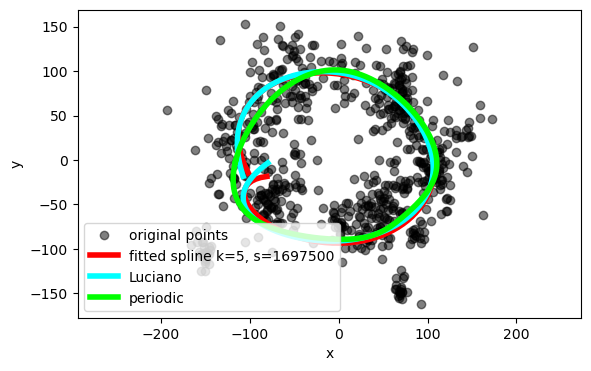

fov_1_veg_pick_2_ring_0_rot_xy_update.hdf5
angle -179.8802032470703 179.95553588867188
[[-1.8169547e+02 -1.5782048e+02 -1.3242984e+02 ... -1.0206265e+02
  -1.0661734e+02 -1.5448453e+02]
 [-3.7989733e-01 -4.7337714e-01 -1.1936342e+00 ...  9.4289750e-01
   8.2469368e-01  1.1987462e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7CF1D88>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7CF16C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][919]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][919]=x[1][0]
  (i, m, i)))


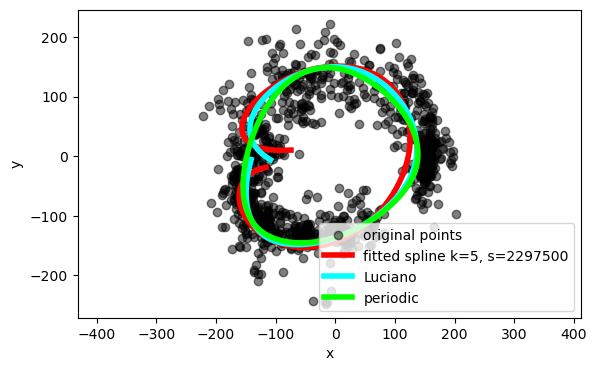

fov_1_veg_pick_3_ring_0_rot_xy_update.hdf5
angle -179.93936157226562 179.92965698242188
[[-190.84744    -178.1365     -179.22633    ... -155.33182
  -181.62868    -169.12088   ]
 [  -0.20196488   -2.2653425    -3.5782313  ...    2.4906614
     1.2057921     0.20760104]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7D40288>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F0E248>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][977]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][977]=x[1][0]
  (i, m, i)))


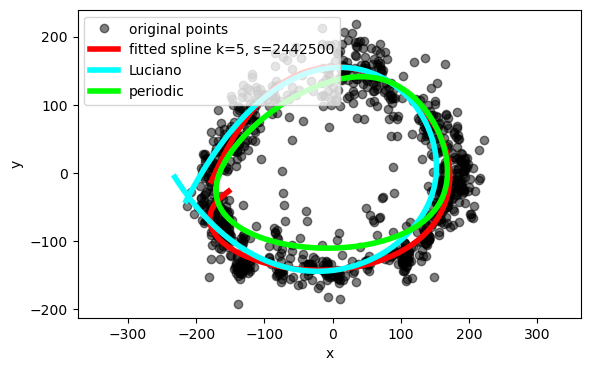

fov_1_veg_pick_4_ring_0_rot_xy_update.hdf5
angle -179.6949462890625 179.35804748535156
[[-128.60152   -158.5156    -134.09372   ... -162.77731   -158.62497
  -154.24606  ]
 [  -0.6846858   -1.6256739   -2.625512  ...    4.5244327    2.6165137
     1.728269 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F18948>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E40EC8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][728]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][728]=x[1][0]
  (i, m, i)))


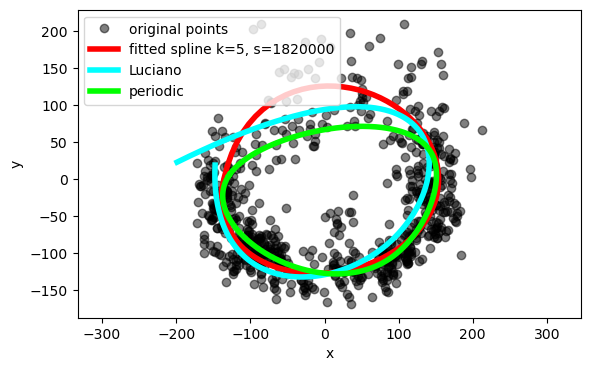

fov_1_veg_pick_5_ring_0_rot_xy_update.hdf5
angle -179.65843200683594 179.9564666748047
[[-3.4384503e+02 -3.1388019e+02 -3.4673959e+02 ... -3.4346219e+02
  -3.4326691e+02 -3.4899347e+02]
 [-2.0497980e+00 -2.3460896e+00 -2.9614990e+00 ...  7.8781360e-01
   7.7656263e-01  2.6514873e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C634C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1CB7208>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1106]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1106]=x[1][0]
  (i, m, i)))


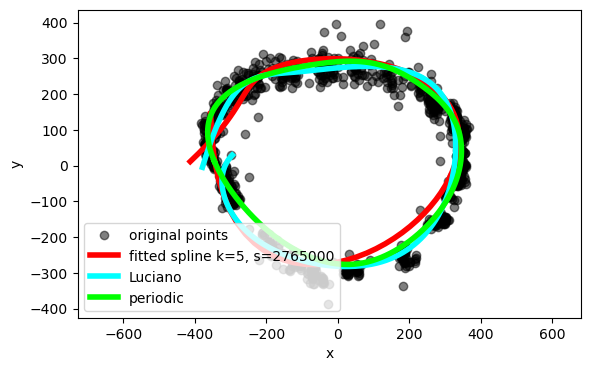

fov_1_veg_pick_6_ring_0_rot_xy_update.hdf5
angle -177.11944580078125 179.8008270263672
[[-250.29991    -187.78427    -294.6749     ... -236.27254
  -236.03427    -242.41708   ]
 [ -12.594441     -9.566283    -21.939302   ...    5.825357
     3.4825263     0.84265864]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7BF6148>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1BC3048>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1507]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1507]=x[1][0]
  (i, m, i)))


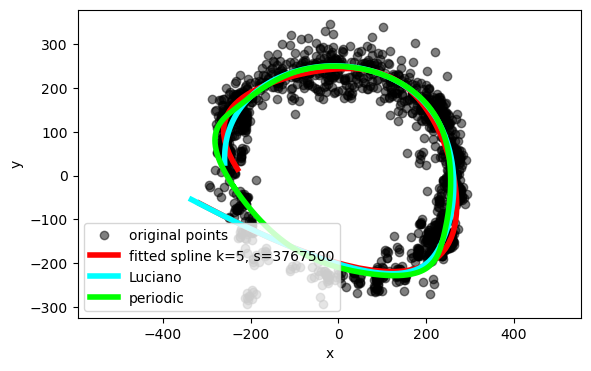

fov_1_veg_pick_7_ring_0_rot_xy_update.hdf5
angle -179.92938232421875 179.6161346435547
[[-173.27643    -192.15923    -212.89752    ... -199.06158
  -198.3975     -192.63579   ]
 [  -0.21352834   -1.2302064    -1.650485   ...    7.8651056
     7.4079285     1.2906238 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DE0248>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E73D08>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1371]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1371]=x[1][0]
  (i, m, i)))


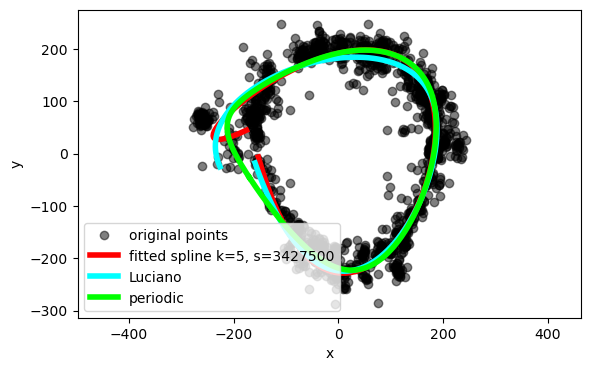

fov_1_veg_pick_8_ring_0_rot_xy_update.hdf5
fov_2_veg_pick_0_ring_0_rot_xy_update.hdf5
angle -179.8842010498047 179.99505615234375
[[-3.1063113e+02 -3.1196317e+02 -3.1567020e+02 ... -3.1189285e+02
  -3.2919757e+02 -3.3748270e+02]
 [-6.2778234e-01 -7.9276758e-01 -2.3018904e+00 ...  1.0129225e+00
   7.2911495e-01  2.9097794e-02]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBACAB7248>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EE9E88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][2285]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][2285]=x[1][0]
  (i, m, i)))


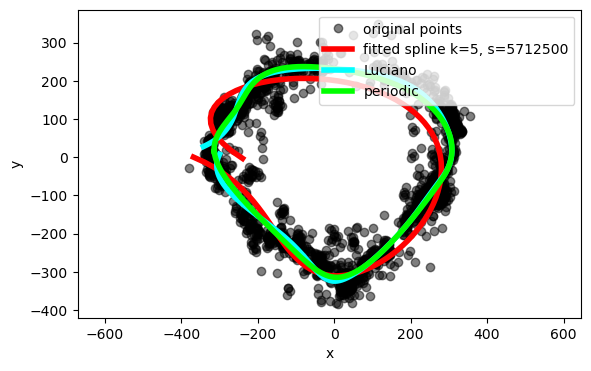

fov_2_veg_pick_1_ring_0_rot_xy_update.hdf5
angle -179.99072265625 179.94247436523438
[[-3.5101056e+02 -2.9323322e+02 -3.0291681e+02 ... -2.8460822e+02
  -3.2722931e+02 -3.1678790e+02]
 [-5.6793083e-02 -3.0737859e-01 -7.4038470e-01 ...  8.5611546e-01
   8.7696874e-01  3.1802133e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E83B48>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E83548>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][2212]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][2212]=x[1][0]
  (i, m, i)))


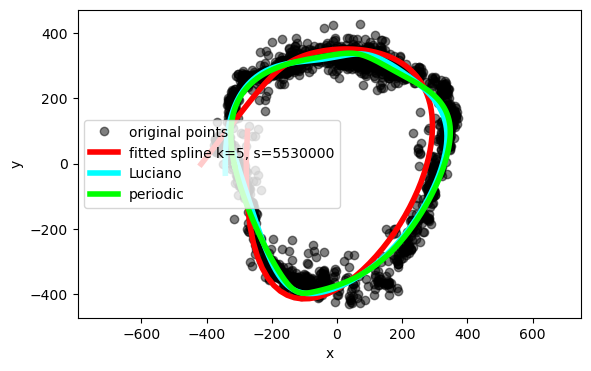

fov_2_veg_pick_2_ring_0_rot_xy_update.hdf5
angle -179.83482360839844 179.9324493408203
[[-273.89612    -259.5211     -268.56403    ... -250.54451
  -266.2125     -285.6539    ]
 [  -0.78960913   -1.307771     -1.5115001  ...    0.7240814
     0.5690497     0.33675542]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7D0BB48>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E67148>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][2625]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][2625]=x[1][0]
  (i, m, i)))


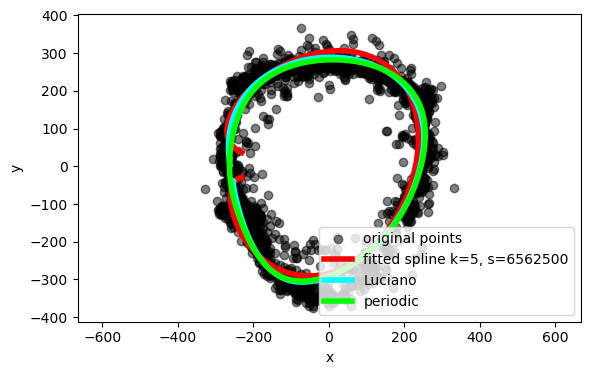

fov_2_veg_pick_3_ring_0_rot_xy_update.hdf5
angle -179.96139526367188 179.92855834960938
[[-2.7383075e+02 -2.8776434e+02 -2.7972137e+02 ... -2.7135419e+02
  -2.6535028e+02 -2.9819012e+02]
 [-1.8447527e-01 -2.0621161e-01 -1.0547619e+00 ...  4.2108211e-01
   4.0417361e-01  3.7179610e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB835DD08>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAEED3048>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1842]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1842]=x[1][0]
  (i, m, i)))


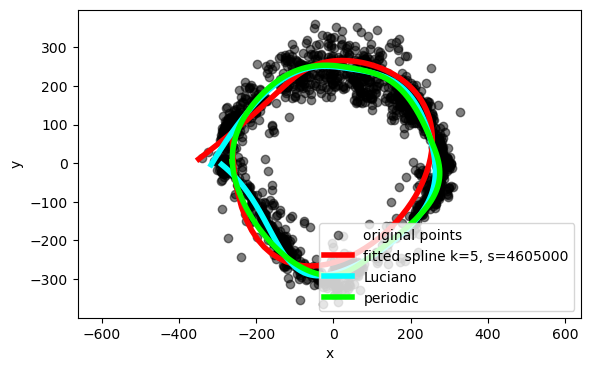

fov_3_veg_pick_0_ring_0_rot_xy_update.hdf5
angle -179.8883056640625 179.828369140625
[[-295.5586     -286.01562    -311.03903    ... -310.1836
  -294.2695     -278.85156   ]
 [  -0.57618076   -0.8352543    -1.5623358  ...    1.7174133
     1.4721395     0.83527553]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8198CC8>, <scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB8248F08>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][3026]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][3026]=x[1][0]
  (i, m, i)))


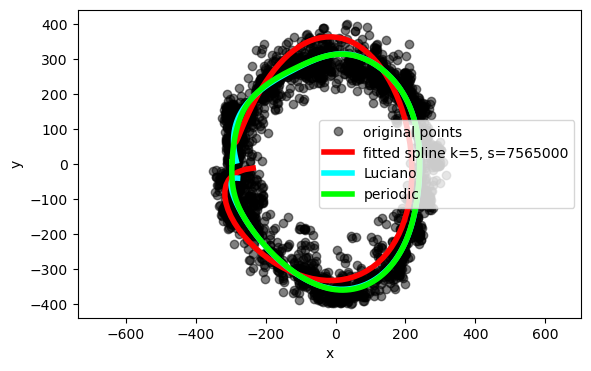

fov_3_veg_pick_1_ring_0_rot_xy_update.hdf5
fov_3_veg_pick_2_ring_0_rot_xy_update.hdf5
fov_3_veg_pick_3_ring_0_rot_xy_update.hdf5
angle -179.85540771484375 179.8206787109375
[[-134.12515    -174.07437    -189.2814     ... -286.12515
  -158.47281    -182.53142   ]
 [  -0.33847538   -2.8670335    -3.6018746  ...    8.711728
     2.3788226     0.57125825]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C94C88>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB83C4FC8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1810]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1810]=x[1][0]
  (i, m, i)))


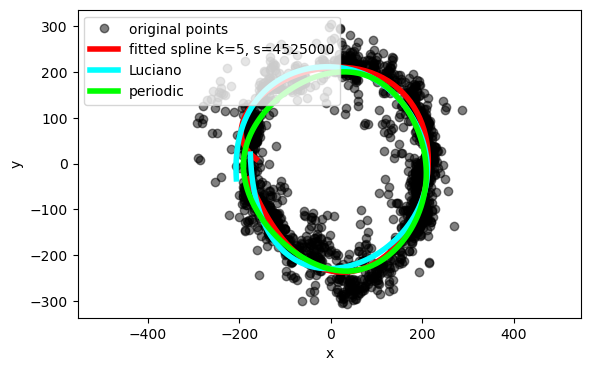

fov_3_veg_pick_4_ring_0_rot_xy_update.hdf5
angle -179.9067840576172 179.80520629882812
[[-149.50052    -161.89505     -77.91459    ... -120.93802
  -150.35208    -151.4185    ]
 [  -0.24321976   -1.0777185    -0.5315989  ...    0.5292673
     0.5655076     0.5147888 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1BF9388>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1D0D1C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1911]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1911]=x[1][0]
  (i, m, i)))


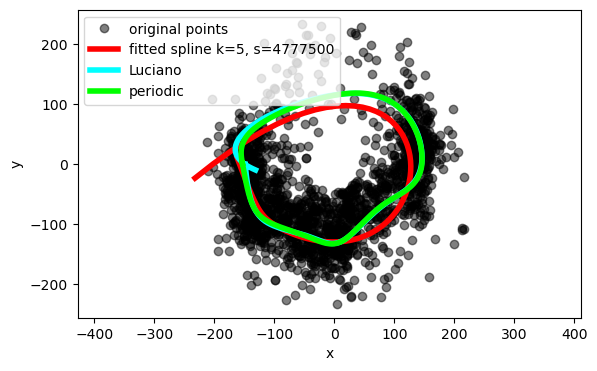

fov_4_spor_pick_0_ring_0_rot_xy_update.hdf5
fov_4_spor_pick_1_ring_0_rot_xy_update.hdf5
angle -179.65318298339844 179.64599609375
[[-156.64032    -161.22235    -152.24577    ... -151.19499
  -157.445      -146.14813   ]
 [  -0.94817454   -2.621178     -4.509835   ...    4.916209
     2.1642525     0.9029921 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB83C9208>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3686FC8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1276]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1276]=x[1][0]
  (i, m, i)))


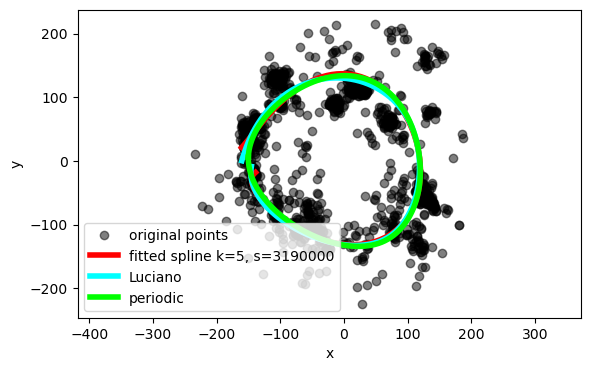

fov_5_spor_pick_0_ring_0_rot_xy_update.hdf5
angle -178.82568359375 178.529052734375
[[-155.79742   -151.17242   -165.33649   ... -164.53961   -153.32867
  -145.7779   ]
 [  -3.1936038   -3.6478164  -12.321062  ...   10.026983     8.0589075
     3.7433527]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE37F7648>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE37DA748>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][704]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][704]=x[1][0]
  (i, m, i)))


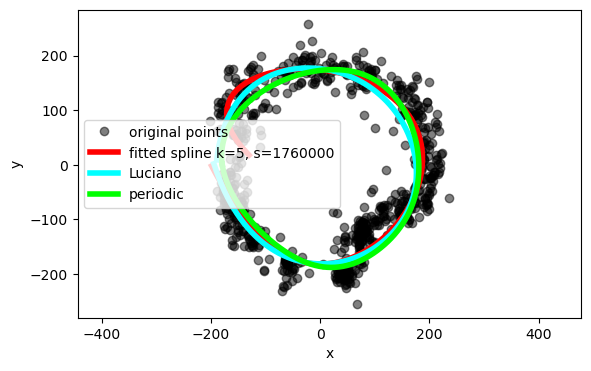

fov_5_spor_pick_1_ring_0_rot_xy_update.hdf5
angle -179.7266845703125 179.8988037109375
[[-451.68314   -438.44098   -426.24176   ... -431.16364   -431.42145
  -433.98004  ]
 [  -2.1546314   -2.2820306   -3.4710054 ...    1.3512388    0.7716105
     0.7664605]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBE37D6348>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE38067C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][834]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][834]=x[1][0]
  (i, m, i)))


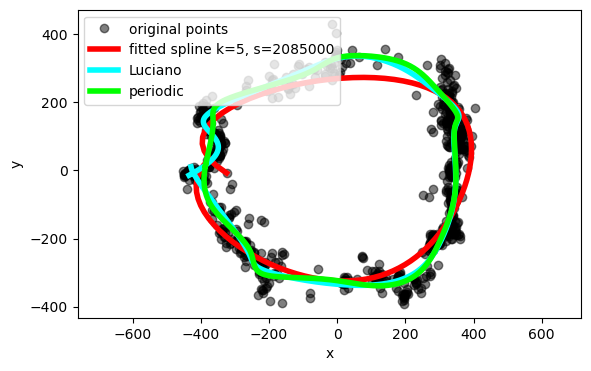

fov_5_spor_pick_2_ring_0_rot_xy_update.hdf5
angle -177.38966369628906 179.15013122558594
[[-153.1464    -245.92763   -250.53311   -238.6464    -237.49403
  -221.36905   -237.41982   -186.49406   -194.79486   -198.81044
  -175.58778   -240.62685   -244.29092   -184.88857   -195.7714
  -199.91978   -198.37685   -207.06435   -242.36122   -200.59558
  -195.8925    -198.99402   -232.88466   -193.22453   -201.13855
  -229.01357   -199.47058   -199.63075   -195.95888   -193.79092
  -175.81825   -178.48233   -175.58385   -172.38466   -179.43935
  -157.28311   -167.3768    -146.7284    -156.4745    -156.15813
  -146.06827   -141.86124   -147.96672   -141.96275    -91.298706
  -146.3925     -89.744026  -147.56046    -98.36903   -152.73227
  -144.5409    -142.54478   -146.93152   -148.66586   -144.36122
  -144.90417   -139.41197   -143.26357   -141.29091   -144.26749
  -144.63466   -141.51357   -139.03308   -132.20497   -150.26747
  -146.90417   -139.00574   -146.13077   -140.04095   -145.31047
 

W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][380]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][380]=x[1][0]
  (i, m, i)))


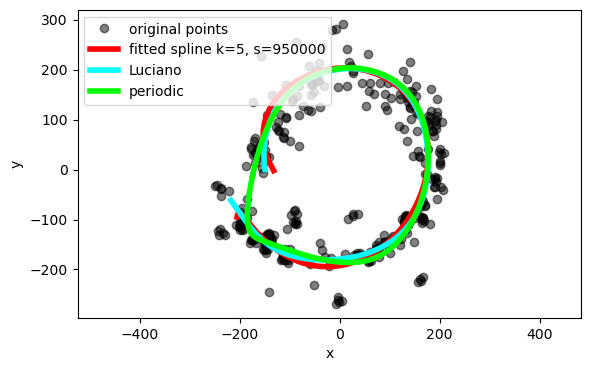

fov_5_spor_pick_3_ring_0_rot_xy_update.hdf5
angle -178.0484619140625 177.8032684326172
[[-1.08968933e+02 -1.18355652e+02 -1.15886902e+02 -1.13777519e+02
  -1.19785339e+02 -9.95861206e+01 -1.27953300e+02 -1.12605659e+02
  -1.25933777e+02 -1.24246269e+02 -1.29168152e+02 -1.25465027e+02
  -1.31980652e+02 -1.10234550e+02 -1.00093933e+02 -1.04527527e+02
  -1.02793152e+02 -9.92970505e+01 -9.01954956e+01 -9.68947220e+01
  -9.16993866e+01 -8.60392456e+01 -8.75548630e+01 -7.02150269e+01
  -5.59220428e+01 -4.29064255e+01 -5.24532890e+01 -4.35626907e+01
  -4.35431442e+01 -4.79259605e+01 -4.98322220e+01 -4.37775116e+01
  -3.85822105e+01 -4.73322105e+01 -4.62306671e+01 -8.99610825e+01
  -4.52736206e+01 -2.61447182e+01 -5.11017342e+01 -7.06564178e+01
  -4.18634758e+01 -7.43009644e+01 -6.52931519e+01 -5.63126678e+01
  -3.96407890e+01 -2.58322010e+01 -3.53321953e+01 -2.17150116e+01
  -1.97853298e+01 -1.49494066e+01 -1.49259491e+01 -1.85314484e+01
  -9.37518501e+00 -1.54314995e+00 -8.51745725e-01  1.64

W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][443]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][443]=x[1][0]
  (i, m, i)))


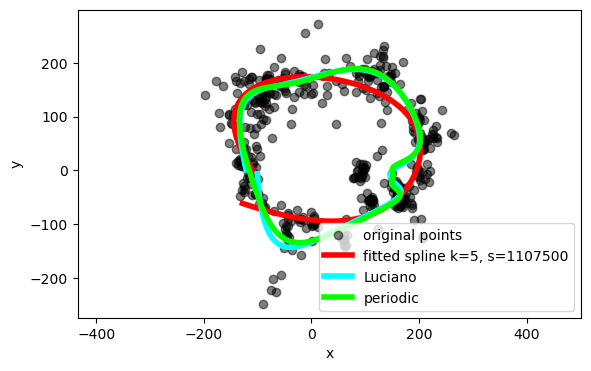

fov_6_spor_pick_0_ring_0_rot_xy_update.hdf5
fov_6_spor_pick_1_ring_0_rot_xy_update.hdf5
angle -179.87240600585938 179.6812744140625
[[-260.68488    -281.83722    -247.7044     ... -265.96222
  -265.5833     -250.2044    ]
 [  -0.58054113   -2.3779368    -4.1806893  ...    5.4967227
     4.193629      1.3918251 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3729588>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3799588>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1760]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1760]=x[1][0]
  (i, m, i)))


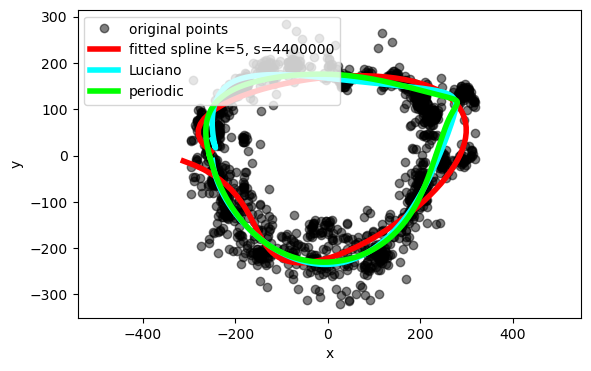

fov_6_spor_pick_2_ring_0_rot_xy_update.hdf5
fov_6_spor_pick_3_ring_0_rot_xy_update.hdf5
fov_6_spor_pick_4_ring_0_rot_xy_update.hdf5
angle -173.34829711914062 175.77352905273438
[[-224.15744  -212.48947  -222.99728  ... -232.83322  -223.45432
  -241.83322 ]
 [ -26.140884  -33.882835  -36.049423 ...   18.203268   16.824795
    17.871473]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB81CA5C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE38665C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][582]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][582]=x[1][0]
  (i, m, i)))


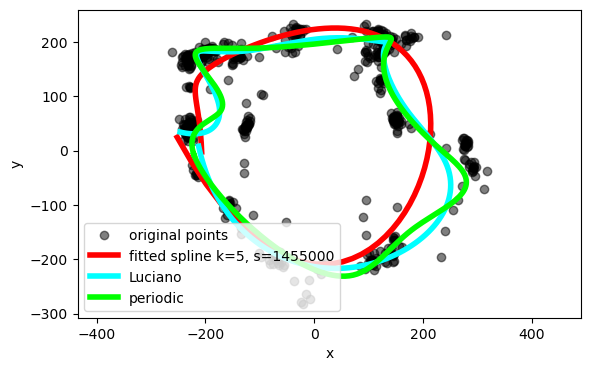

fov_6_spor_pick_5_ring_0_rot_xy_update.hdf5
fov_7_veg_pick_0_ring_0_rot_xy_update.hdf5
angle -179.0084686279297 179.7959747314453
[[-156.90207   -166.76926   -191.26144   ... -193.46066   -156.86691
  -169.31613  ]
 [  -2.7155063   -2.9688866   -6.3959365 ...    3.7771463    2.7573597
     0.6029259]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBACAB5CC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB80ACA48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1518]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1518]=x[1][0]
  (i, m, i)))


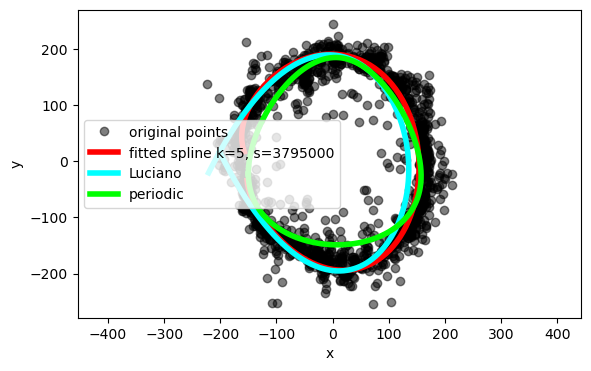

fov_7_veg_pick_1_ring_0_rot_xy_update.hdf5
angle -179.88946533203125 179.4262237548828
[[-347.17627   -343.08252   -336.2192    ... -272.0786    -268.18408
  -373.89893  ]
 [  -0.6697718   -3.364235    -5.3975883 ...    4.020305     3.2563486
     3.7444265]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DF3408>, <scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBAF286F48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1282]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1282]=x[1][0]
  (i, m, i)))


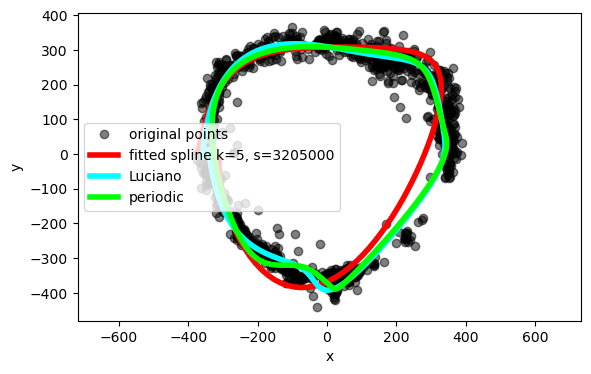

fov_7_veg_pick_2_ring_0_rot_xy_update.hdf5
angle -179.56251525878906 179.98326110839844
[[-3.1921460e+02 -3.0256226e+02 -3.2698022e+02 ... -2.9555054e+02
  -3.1176541e+02 -3.1674582e+02]
 [-2.4374125e+00 -2.5137706e+00 -2.7882128e+00 ...  4.8323126e+00
   1.8593019e+00  9.2481971e-02]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB83A17C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB83525C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1229]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1229]=x[1][0]
  (i, m, i)))


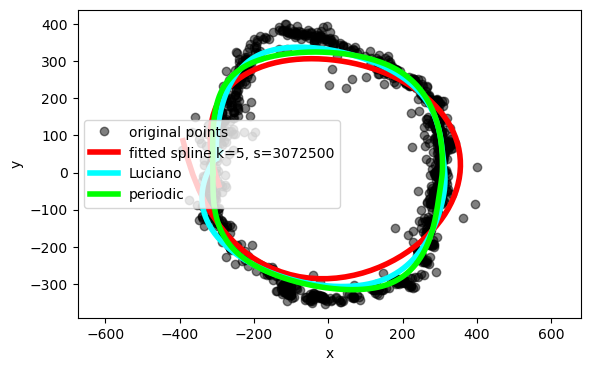

fov_7_veg_pick_3_ring_0_rot_xy_update.hdf5
angle -179.83932495117188 179.83554077148438
[[-353.00296   -341.0655    -356.3233    ... -352.60065   -356.04987
  -356.36627  ]
 [  -0.9898907   -3.222877    -5.6877885 ...    1.4058214    1.2086217
     1.0228574]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7CCCF48>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAEEDE908>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1298]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1298]=x[1][0]
  (i, m, i)))


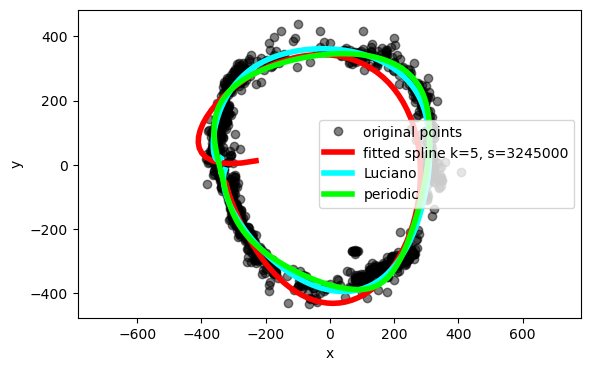

fov_7_veg_pick_4_ring_0_rot_xy_update.hdf5
angle -179.5608367919922 179.73757934570312
[[-374.95093   -392.29465   -386.13455   ... -381.13843   -374.15405
  -387.57205  ]
 [  -2.873992    -7.013805    -9.362352  ...    4.3411283    3.8532364
     1.7750666]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF8AB808>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C23108>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1247]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1247]=x[1][0]
  (i, m, i)))


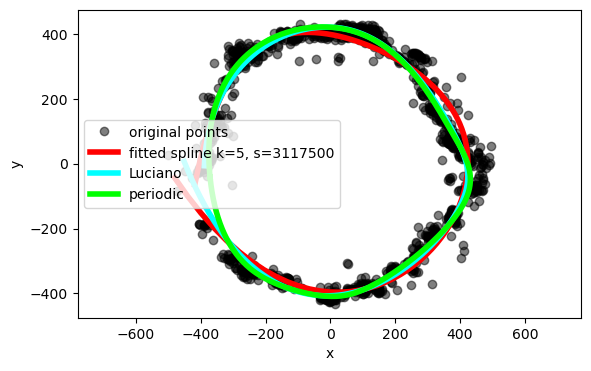

fov_7_veg_pick_5_ring_0_rot_xy_update.hdf5
angle -179.9149932861328 179.40101623535156
[[-314.596      -313.59598    -319.0335     ... -321.21317
  -317.6546     -334.20535   ]
 [  -0.46673223   -2.0082445    -3.404324   ...    7.276849
     5.9086466     3.4939406 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EDD748>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DB4408>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1219]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1219]=x[1][0]
  (i, m, i)))


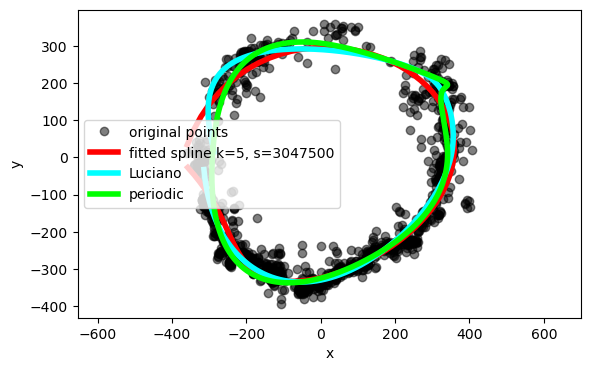

fov_7_veg_pick_6_ring_0_rot_xy_update.hdf5
angle -179.44918823242188 179.8294219970703
[[-175.89584    -200.5599     -196.85287    ... -184.91145
  -175.4349     -212.95444   ]
 [  -1.6910139    -4.07079      -5.3066173  ...   11.089721
     6.5783443     0.63397694]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E8DAC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1CE58C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1102]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1102]=x[1][0]
  (i, m, i)))


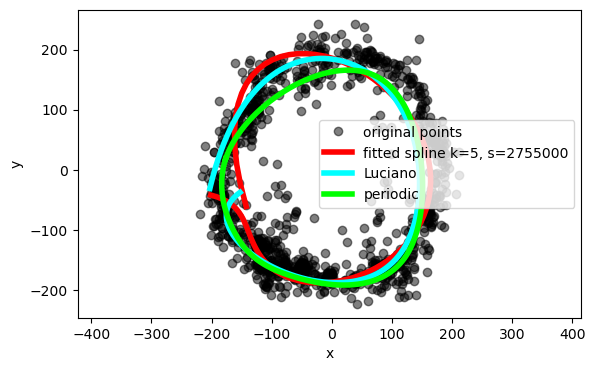

fov_7_veg_pick_7_ring_0_rot_xy_update.hdf5
angle -179.6910858154297 179.9398651123047
[[-2.7117435e+02 -2.7919778e+02 -2.7031497e+02 ... -2.6541263e+02
  -2.7869775e+02 -2.6282669e+02]
 [-1.4620534e+00 -2.1835160e+00 -3.6348755e+00 ...  6.2194448e+00
   1.2001437e+00  2.7581862e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7ECFA08>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E2C348>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1164]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1164]=x[1][0]
  (i, m, i)))


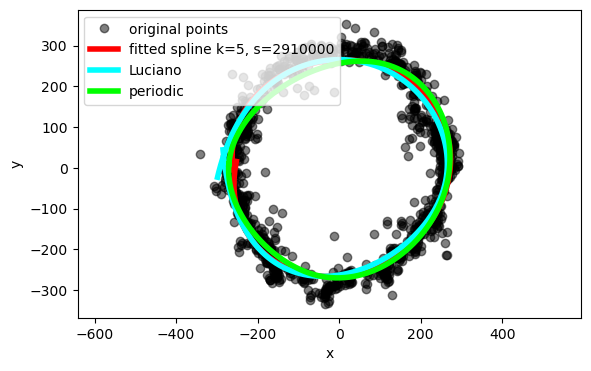

fov_7_veg_pick_8_ring_0_rot_xy_update.hdf5
angle -179.8999786376953 179.8821258544922
[[-289.821     -295.67258   -271.7859    ... -290.73898   -273.4148
  -282.4734   ]
 [  -0.505916    -1.1885772   -1.8980289 ...    0.6867052    0.608043
     0.5811126]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAD26FBC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7D266C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1178]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1178]=x[1][0]
  (i, m, i)))


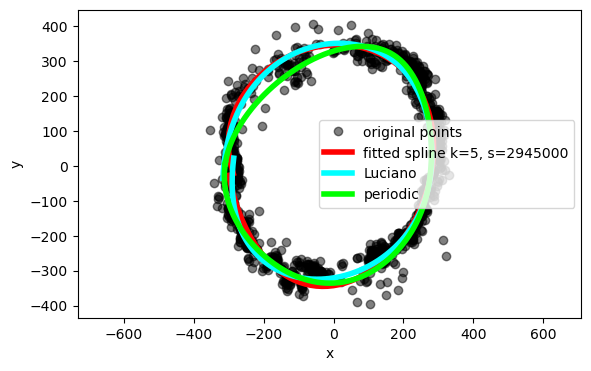

fov_7_veg_pick_9_ring_0_rot_xy_update.hdf5
angle -179.58937072753906 179.78378295898438
[[-203.2851     -218.30853    -218.60541    ... -180.18353
  -206.48042    -209.48042   ]
 [  -1.4569235    -7.8337727    -7.910024   ...    1.294579
     1.392094      0.79049945]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB80E7FC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3682748>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][886]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][886]=x[1][0]
  (i, m, i)))


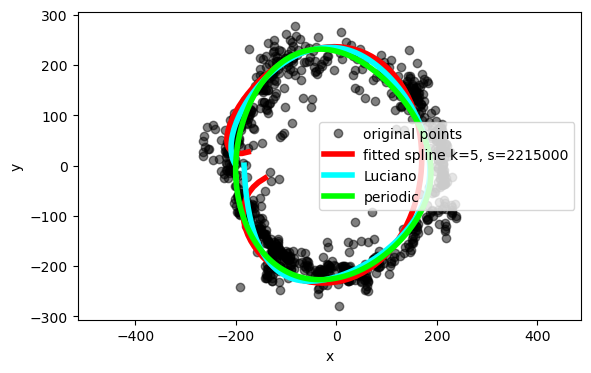

fov_7_veg_pick_10_ring_0_rot_xy_update.hdf5
angle -179.89849853515625 179.9376678466797
[[-250.40547    -257.72183    -255.97185    ... -255.07733
  -251.7531     -250.60858   ]
 [  -0.44361904   -2.8344579    -3.9736757  ...    2.5549695
     2.2512462     0.27261627]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F63A48>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F87788>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1210]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1210]=x[1][0]
  (i, m, i)))


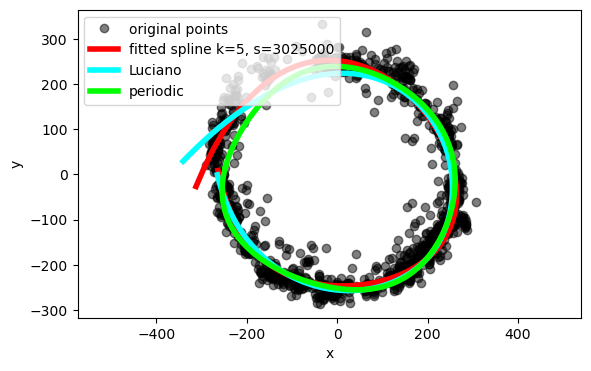

fov_7_veg_pick_11_ring_0_rot_xy_update.hdf5
angle -179.64080810546875 179.7039031982422
[[-156.50287    -162.26848    -166.09662    ... -160.8466
  -196.51068    -168.61615   ]
 [  -0.98111224   -5.314729     -5.9574265  ...    1.9585954
     1.5614455     0.8713546 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F901C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8115848>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][973]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][973]=x[1][0]
  (i, m, i)))


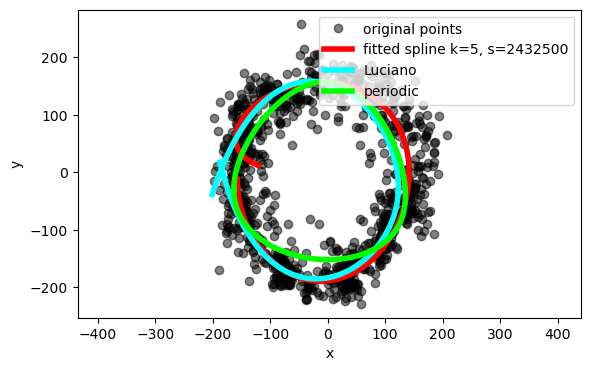

fov_7_veg_pick_12_ring_0_rot_xy_update.hdf5
angle -179.69789123535156 178.37045288085938
[[-239.93361   -235.8164    -189.3164    ... -246.34375   -237.55861
  -201.5625   ]
 [  -1.2651284   -1.3341657   -3.0715694 ...   20.976234    19.47584
     5.734158 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7D0A908>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F7E348>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1331]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1331]=x[1][0]
  (i, m, i)))


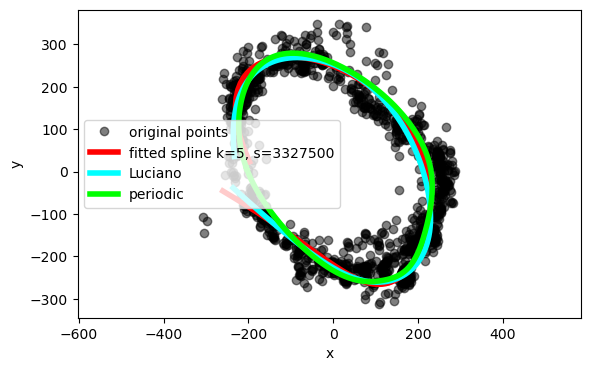

fov_7_veg_pick_13_ring_0_rot_xy_update.hdf5
angle -179.86524963378906 179.52198791503906
[[-202.18474    -230.7355     -194.19644    ... -214.00896
  -266.3214     -203.94644   ]
 [  -0.47552156   -1.600624     -1.8444469  ...    4.153169
     3.864359      1.701543  ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB82C6388>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB82C6F88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1208]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1208]=x[1][0]
  (i, m, i)))


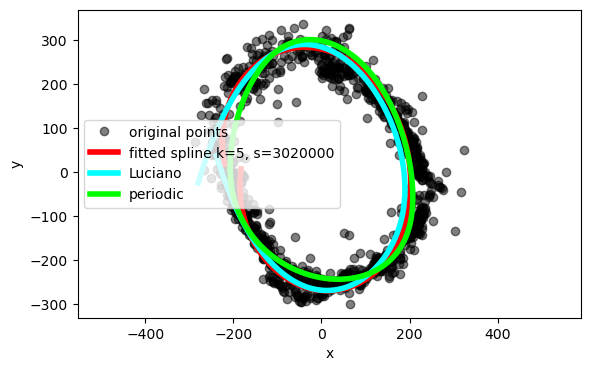

fov_7_veg_pick_14_ring_0_rot_xy_update.hdf5
angle -179.6387939453125 179.77171325683594
[[-214.00612    -213.99437    -206.65456    ... -213.16626
  -221.74437    -224.02954   ]
 [  -1.3491502    -2.9819498    -3.163529   ...    2.478111
     2.4346488     0.89261985]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8391848>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8391D08>]


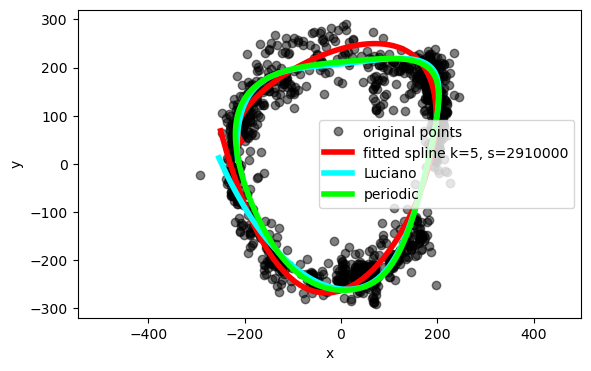

fov_7_veg_pick_15_ring_0_rot_xy_update.hdf5
angle -170.72215270996094 178.9327850341797
[[-375.1615    -357.97394   -357.68494   ... -362.4037    -415.5287
  -392.68494  ]
 [ -61.28605   -143.07338   -148.08105   ...   90.29212    100.344154
     7.3151383]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB7D3C588>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F7E1C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][749]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][749]=x[1][0]
  (i, m, i)))


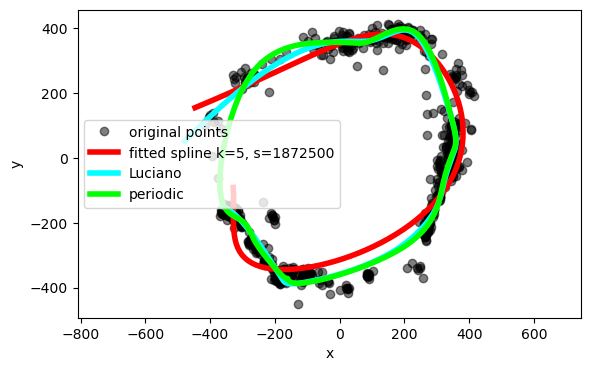

fov_7_veg_pick_16_ring_0_rot_xy_update.hdf5
angle -179.8945770263672 179.40264892578125
[[-384.60873   -405.9681    -394.71808   ... -382.26498   -308.0931
  -417.2767   ]
 [  -0.7075996   -2.9871616   -4.6474276 ...    7.0346923    4.400895
     4.350567 ]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB80BEE08>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE36A2308>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1191]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1191]=x[1][0]
  (i, m, i)))


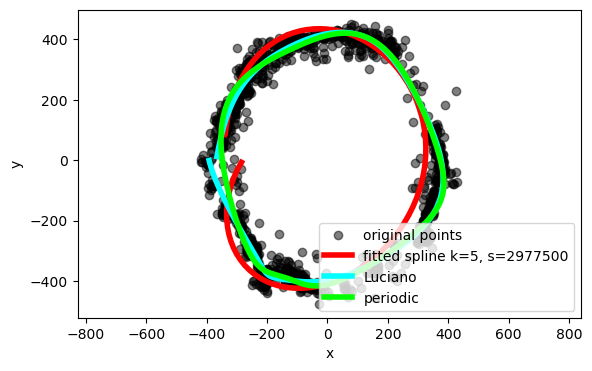

fov_7_veg_pick_17_ring_0_rot_xy_update.hdf5
angle -178.96240234375 178.76345825195312
[[-176.97409   -182.70847   -179.9155    ... -179.33347   -175.5444
  -172.50534  ]
 [  -3.205258    -4.585533    -5.6063123 ...    9.374305     7.232806
     3.723513 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DD0788>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E8AA08>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1121]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1121]=x[1][0]
  (i, m, i)))


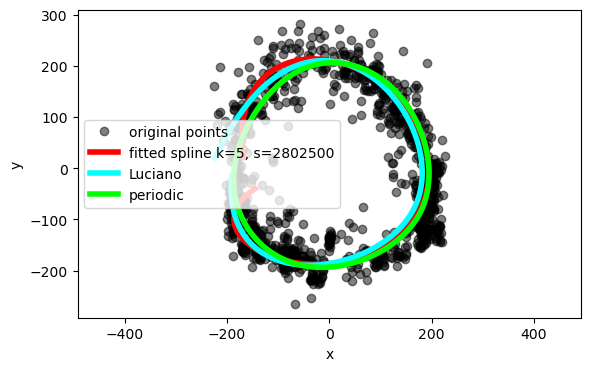

fov_7_veg_pick_18_ring_0_rot_xy_update.hdf5
angle -179.8783721923828 179.5554962158203
[[-271.32782   -264.32782   -274.61688   ... -276.41766   -261.6481
  -273.42938  ]
 [  -0.5759733   -2.84818     -3.7059505 ...    4.691014     2.2276216
     2.1213224]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DCA588>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EEE748>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1409]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1409]=x[1][0]
  (i, m, i)))


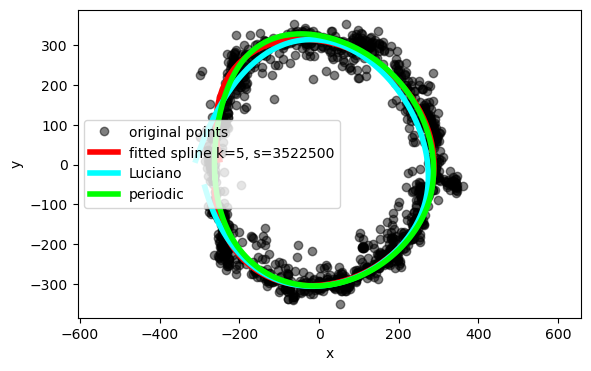

fov_7_veg_pick_19_ring_0_rot_xy_update.hdf5
angle -179.83863830566406 179.96923828125
[[-3.2559109e+02 -2.7967706e+02 -3.1183719e+02 ... -3.2566147e+02
  -3.2600516e+02 -3.0663409e+02]
 [-9.1690379e-01 -8.3047998e-01 -1.1966063e+00 ...  3.6041081e+00
   3.0004232e+00  1.6461077e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E85E48>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F91648>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1579]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1579]=x[1][0]
  (i, m, i)))


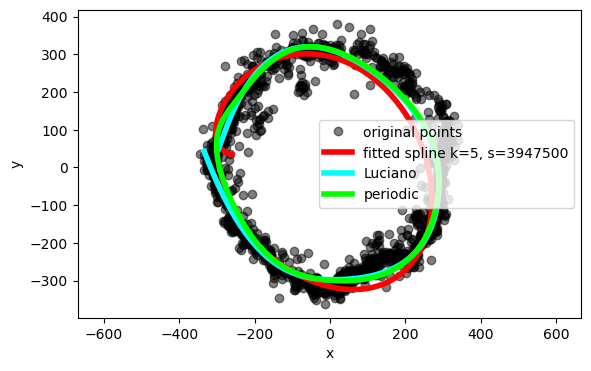

fov_8_spor_pick_0_ring_0_rot_xy_update.hdf5
angle -179.97955322265625 179.6827850341797
[[-3.1109012e+02 -2.2712918e+02 -3.1980887e+02 ... -2.8374637e+02
  -2.2966043e+02 -3.0243387e+02]
 [-1.1100480e-01 -1.3624021e+00 -3.4838221e+00 ...  1.6955786e+01
   3.3994381e+00  1.6744328e+00]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1D33808>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1BFBEC8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1406]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1406]=x[1][0]
  (i, m, i)))


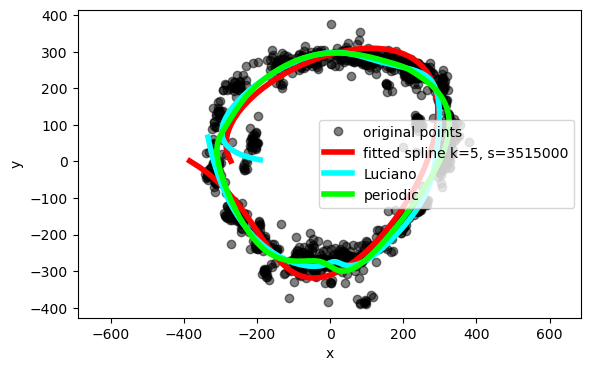

fov_8_spor_pick_1_ring_0_rot_xy_update.hdf5
angle -179.99388122558594 179.99560546875
[[-3.5034122e+02 -2.0903262e+02 -3.3441934e+02 ... -2.1068105e+02
  -3.4529044e+02 -3.4345840e+02]
 [-3.7389852e-02 -1.0419145e-01 -4.0979230e-01 ...  1.0851661e+00
   1.3982447e+00  2.6337545e-02]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB1C0C7C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1BFFC48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1373]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1373]=x[1][0]
  (i, m, i)))


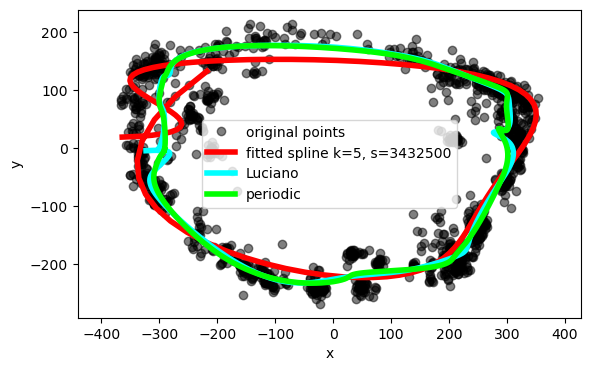

fov_8_spor_pick_2_ring_0_rot_xy_update.hdf5
angle -177.52037048339844 179.22398376464844
[[-343.3856    -314.71765   -319.19812   ... -355.03406   -343.97546
  -293.29578  ]
 [ -14.870209   -23.391247   -25.596083  ...   11.64247      9.631871
     3.9726396]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB821A288>, <scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB81944C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][759]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][759]=x[1][0]
  (i, m, i)))


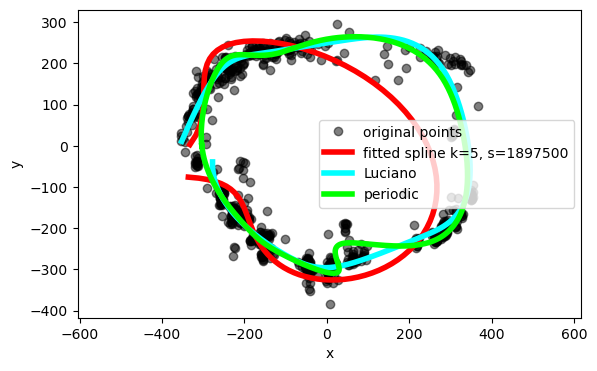

fov_8_spor_pick_3_ring_0_rot_xy_update.hdf5
angle -179.85269165039062 179.97254943847656
[[-2.21390198e+02 -2.29230026e+02 -2.30839417e+02 ... -2.37620667e+02
  -2.31245667e+02 -2.31960510e+02]
 [-5.69199562e-01 -1.14884388e+00 -1.91248357e+00 ...  6.92113101e-01
   3.85196239e-01  1.11140154e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F1F688>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C9B448>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1123]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1123]=x[1][0]
  (i, m, i)))


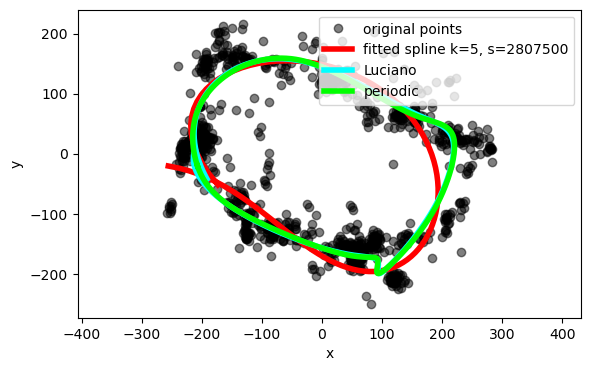

fov_8_spor_pick_4_ring_0_rot_xy_update.hdf5
angle -179.9106903076172 179.73855590820312
[[-271.87762    -277.237      -283.8581     ... -292.35812
  -263.33466    -291.9284    ]
 [  -0.42377418   -0.7501289    -3.4174926  ...    1.8809522
     1.3072107     1.3320802 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF286C88>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB82A4F48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1057]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1057]=x[1][0]
  (i, m, i)))


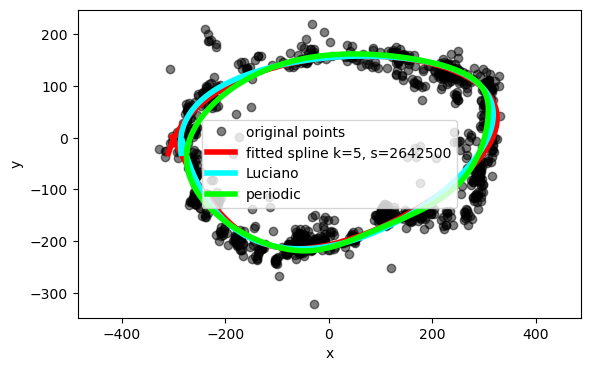

fov_8_spor_pick_5_ring_0_rot_xy_update.hdf5
angle -179.65992736816406 179.82154846191406
[[-263.15033    -246.65814    -258.248      ... -256.15424
  -256.97455    -226.42767   ]
 [  -1.5619059    -1.7177844    -2.6695497  ...    8.589909
     7.0033        0.70523685]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF348FC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE36A0548>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1340]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1340]=x[1][0]
  (i, m, i)))


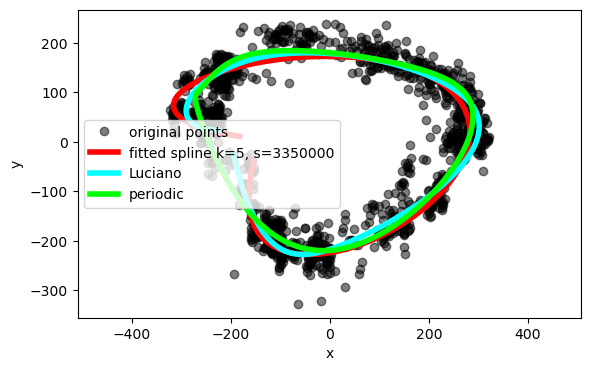

fov_8_spor_pick_6_ring_0_rot_xy_update.hdf5
angle -179.82122802734375 179.9595947265625
[[-1.4488150e+02 -2.9576041e+02 -3.0545181e+02 ... -2.8274866e+02
  -2.9020963e+02 -3.0037372e+02]
 [-4.5204574e-01 -1.0201861e+00 -2.0487278e+00 ...  1.3158101e+00
   3.4143421e-01  2.1180998e-01]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBE3705D08>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3728548>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][933]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][933]=x[1][0]
  (i, m, i)))


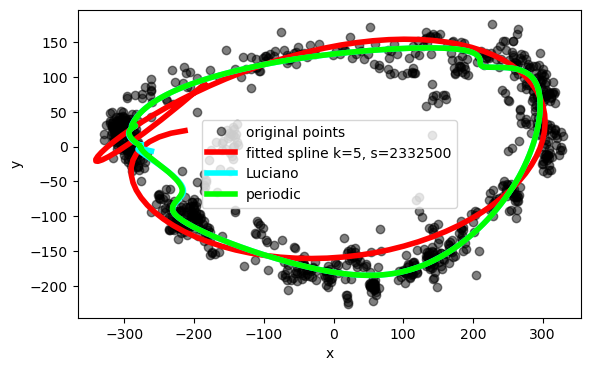

fov_8_spor_pick_7_ring_0_rot_xy_update.hdf5
angle -179.97772216796875 179.8872833251953
[[-3.1971448e+02 -3.0544498e+02 -3.1178088e+02 ... -3.1289417e+02
  -3.1956213e+02 -2.9343326e+02]
 [-1.2422023e-01 -2.7969205e+00 -3.9199786e+00 ...  3.2615931e+00
   2.3984642e+00  5.7721460e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3772D88>, <scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBE372B708>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][985]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][985]=x[1][0]
  (i, m, i)))


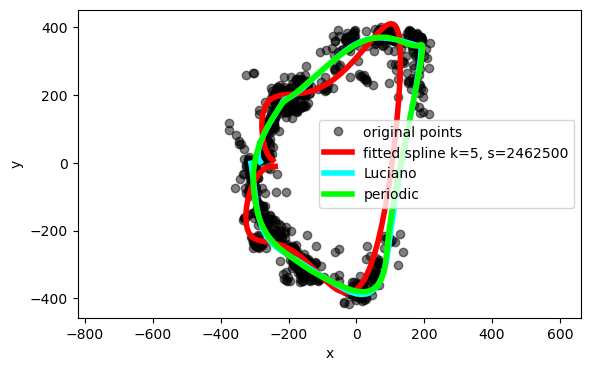

fov_8_spor_pick_8_ring_0_rot_xy_update.hdf5
angle -179.9697723388672 179.848388671875
[[-3.1834732e+02 -3.1923010e+02 -3.3177307e+02 ... -3.4064417e+02
  -3.3564026e+02 -2.8205820e+02]
 [-1.6786280e-01 -3.5396162e-01 -8.5086089e-01 ...  2.3854823e+00
   1.9866418e+00  7.4629456e-01]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBE372B808>, <scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBE3770308>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1014]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1014]=x[1][0]
  (i, m, i)))


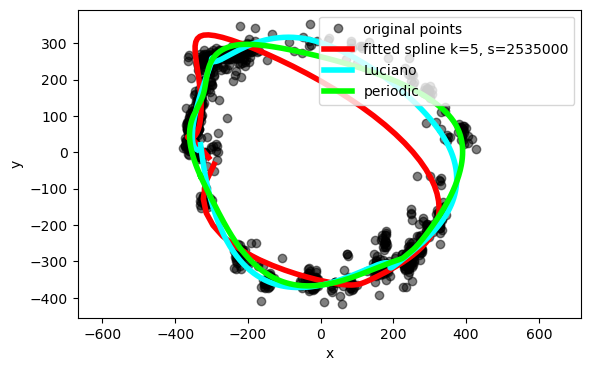

fov_8_spor_pick_9_ring_0_rot_xy_update.hdf5
angle -179.73089599609375 179.1479034423828
[[-353.95187   -347.7175    -348.0339    ... -326.18625   -335.27216
  -329.74875  ]
 [  -1.6623544   -2.5527434   -5.5768003 ...   18.61561     11.81159
     4.9043016]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB816E048>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB816E348>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][938]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][938]=x[1][0]
  (i, m, i)))


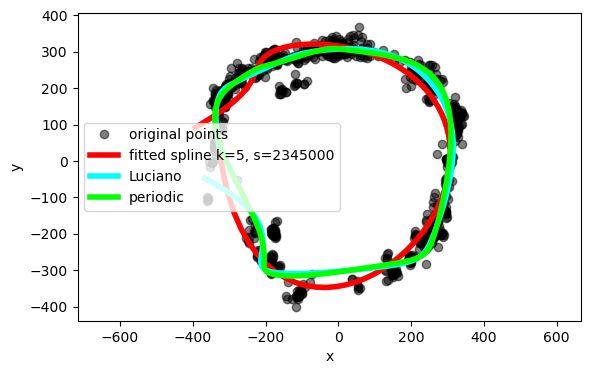

fov_8_spor_pick_10_ring_0_rot_xy_update.hdf5
angle -179.97113037109375 179.7317352294922
[[-3.0387311e+02 -3.0270514e+02 -3.1851764e+02 ... -2.9718564e+02
  -2.9780276e+02 -2.9253326e+02]
 [-1.5313062e-01 -5.4551119e-01 -6.1106628e-01 ...  2.6580834e+00
   1.4043982e+00  1.3696438e+00]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EF5188>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB81E7D08>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][913]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][913]=x[1][0]
  (i, m, i)))


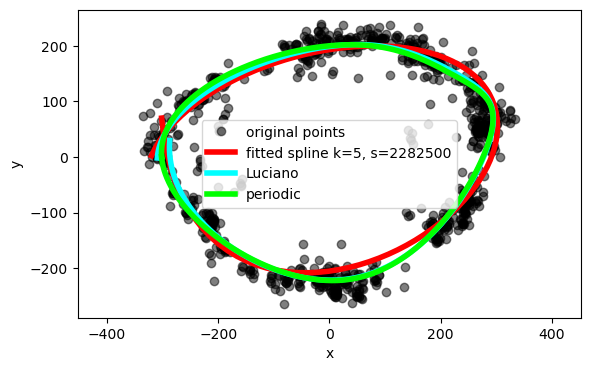

fov_8_spor_pick_11_ring_0_rot_xy_update.hdf5
angle -179.95260620117188 179.97393798828125
[[-2.1446918e+02 -2.1604730e+02 -2.0714104e+02 ... -2.1620355e+02
  -2.1708636e+02 -1.8888324e+02]
 [-1.7736317e-01 -6.7398763e-01 -9.3975973e-01 ...  1.0308247e+00
   1.8527263e-01  8.5906975e-02]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF7664C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE372C2C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][736]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][736]=x[1][0]
  (i, m, i)))


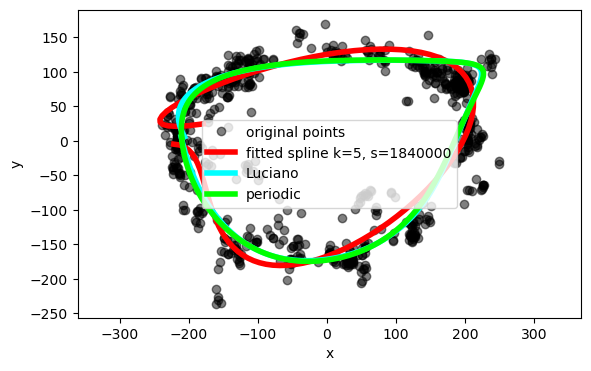

fov_8_spor_pick_12_ring_0_rot_xy_update.hdf5
angle -175.3358917236328 178.5617218017578
[[-101.231384   -114.35248    -101.8681      -48.43451    -104.03607
  -100.04779    -108.063416   -104.75872    -106.18841    -111.282166
   -72.05951    -120.88373    -109.563416    -99.0556     -105.33294
  -100.39545    -101.60638    -136.77434     -57.200134   -114.77435
  -112.82121    -112.829025    -55.51654    -133.03217     -67.21966
   -90.32903     -74.723564    -80.75872     -71.688416    -86.37982
   -73.12201     -73.86029     -76.121994    -69.72356     -70.27826
   -77.000916    -70.00871     -70.797775   -140.81734     -75.52043
  -133.88373    -135.17276    -136.4931     -137.71964     -79.29778
    -3.235291    -65.88764     -66.55951     -62.942307    -64.90714
   -62.14546     -66.6728      -64.20796     -66.96575     -48.246994
   -42.950134    -39.66888     -45.75874     -34.00873     -36.231384
   -30.539978    -39.133728    -60.270435    -42.539974    -43.70793
   -56.39541

W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][441]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][441]=x[1][0]
  (i, m, i)))


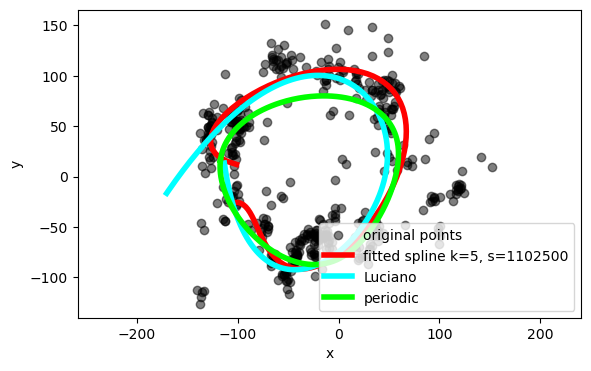

fov_8_spor_pick_13_ring_0_rot_xy_update.hdf5
angle -171.2684783935547 179.1588134765625
[[-256.83917   -255.6009    -261.32355   ... -186.3079    -287.01105
  -286.7923   ]
 [ -39.44652    -52.96316    -56.17824   ...    4.185338     5.6132183
     4.2107725]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB833AC88>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB83BA908>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][824]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][824]=x[1][0]
  (i, m, i)))


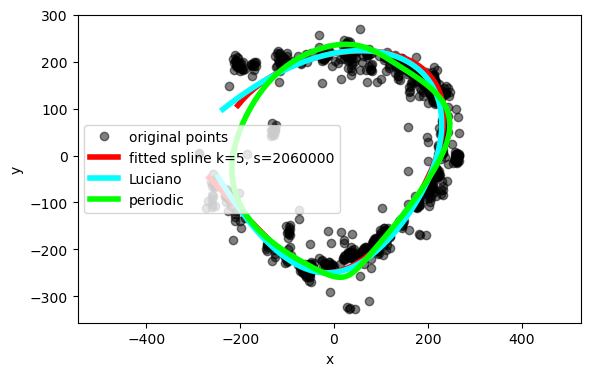

fov_8_spor_pick_14_ring_0_rot_xy_update.hdf5
angle -179.98060607910156 179.91433715820312
[[-3.23257050e+02 -3.24800049e+02 -3.13378143e+02 ... -3.10171112e+02
  -3.26366425e+02 -3.22421112e+02]
 [-1.09411836e-01 -4.10162836e-01 -1.43638194e+00 ...  2.34743023e+00
   1.66508090e+00  4.82031375e-01]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB1BD1808>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF9E9EC8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1350]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1350]=x[1][0]
  (i, m, i)))


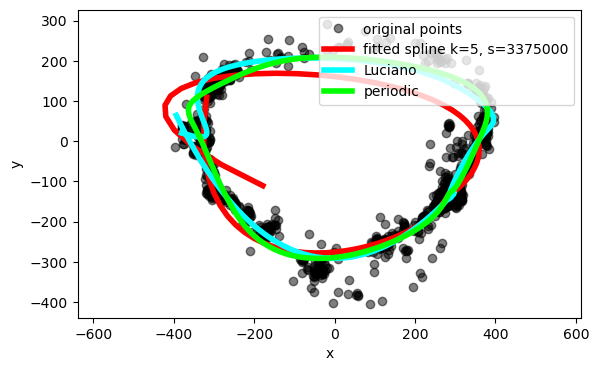

fov_8_spor_pick_15_ring_0_rot_xy_update.hdf5
angle -174.48858642578125 178.8105926513672
[[-255.41562   -292.57968   -267.73984   ... -272.81796   -273.31015
  -279.9625   ]
 [ -24.64507    -82.89138    -82.495     ...    7.5435905    7.4438624
     5.8125815]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB832ACC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB813A488>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][806]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][806]=x[1][0]
  (i, m, i)))


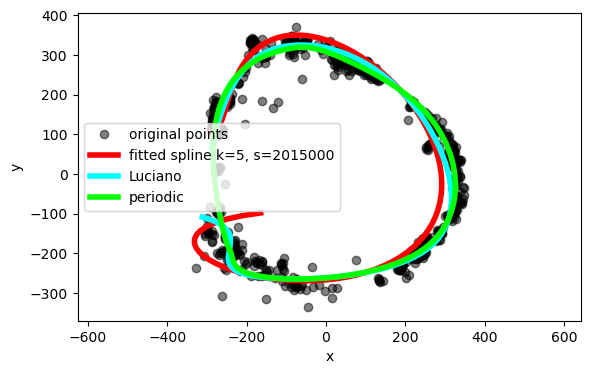

fov_8_spor_pick_16_ring_0_rot_xy_update.hdf5
angle -178.84266662597656 179.7572479248047
[[-165.82848   -180.16443   -165.223     ... -167.56287   -165.1332
  -168.3324   ]
 [  -3.3500605   -4.325178    -6.03981   ...    7.782781     3.107261
     0.7131631]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DAD788>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8050D48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][723]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][723]=x[1][0]
  (i, m, i)))


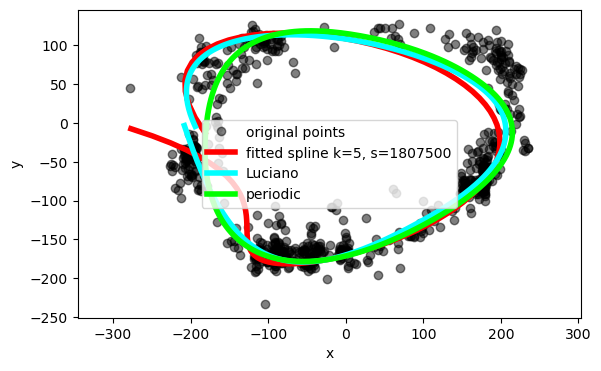

fov_8_spor_pick_17_ring_0_rot_xy_update.hdf5
angle -179.3952178955078 179.96572875976562
[[-2.7615839e+02 -2.5433807e+02 -2.4968964e+02 ... -2.7567010e+02
  -2.5160370e+02 -2.4940057e+02]
 [-2.9150755e+00 -3.9620814e+00 -5.2392058e+00 ...  4.7956810e+00
   1.4069875e+00  1.4916769e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DAD808>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7DAD408>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][939]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][939]=x[1][0]
  (i, m, i)))


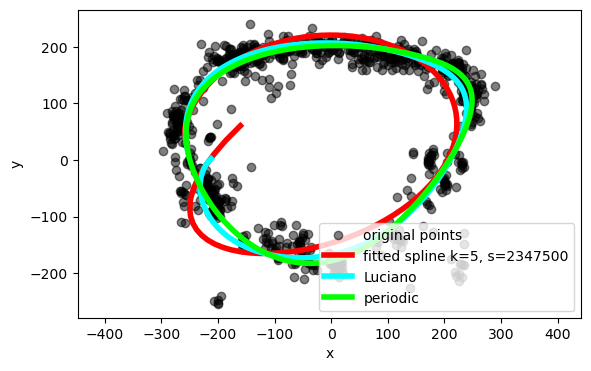

fov_8_spor_pick_18_ring_0_rot_xy_update.hdf5
angle -179.28366088867188 176.55406188964844
[[-317.59317   -315.32755   -314.66736   ... -365.51898   -237.1752
  -332.1713   ]
 [  -3.9708657   -9.760618   -13.329991  ...   22.139803    14.345477
    20.00187  ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E8D988>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F0EA88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1038]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1038]=x[1][0]
  (i, m, i)))


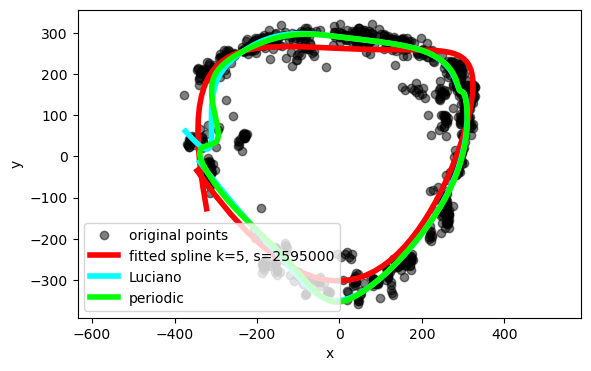

fov_8_spor_pick_19_ring_0_rot_xy_update.hdf5
angle -178.89410400390625 179.97552490234375
[[-2.2932581e+02 -2.4103284e+02 -2.3531799e+02 ... -2.2822424e+02
  -2.2991956e+02 -2.2742735e+02]
 [-4.4268422e+00 -6.1584163e+00 -6.4697475e+00 ...  4.2137585e+00
   4.5808697e-01  9.7093351e-02]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1CF6348>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE35FD348>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][553]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][553]=x[1][0]
  (i, m, i)))


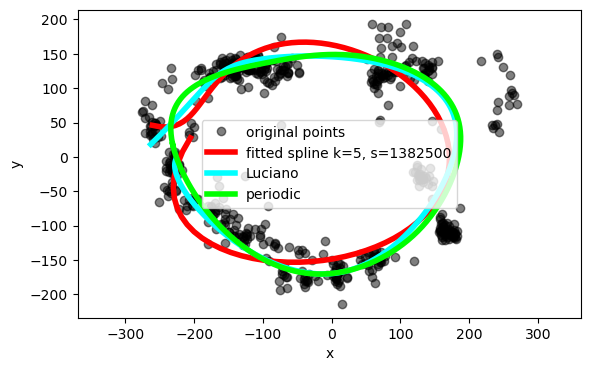

fov_8_spor_pick_20_ring_0_rot_xy_update.hdf5
angle -179.73440551757812 179.51612854003906
[[-196.9962     -184.15637    -183.56653    ... -179.1681
  -264.8517     -269.922     ]
 [  -0.91317946   -1.1428795    -1.52197    ...    4.3577213
     5.50062       2.2795284 ]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB80ADC08>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB82C2B08>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][962]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][962]=x[1][0]
  (i, m, i)))


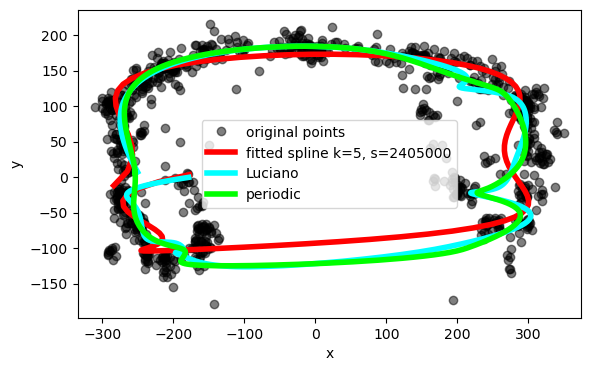

fov_8_spor_pick_21_ring_0_rot_xy_update.hdf5
angle -179.2482147216797 179.98184204101562
[[-1.7143906e+02 -1.7608749e+02 -1.6628671e+02 ... -1.7039607e+02
  -1.7103670e+02 -1.6873982e+02]
 [-2.2495880e+00 -3.0187402e+00 -3.2425938e+00 ...  3.2025931e+00
   3.0665174e+00  5.3451866e-02]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8107F48>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3663E88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][986]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][986]=x[1][0]
  (i, m, i)))


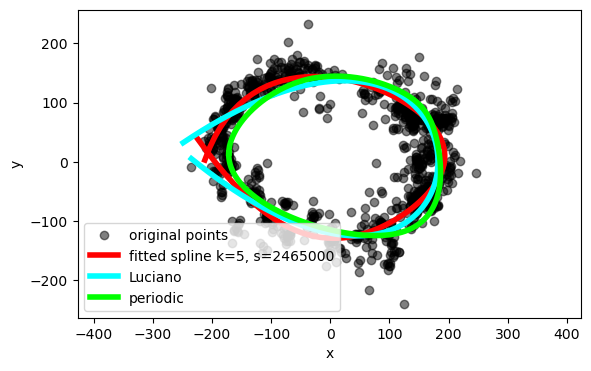

fov_8_spor_pick_22_ring_0_rot_xy_update.hdf5
angle -179.36508178710938 177.7806854248047
[[-268.5523   -272.61868  -261.7476   ... -281.3648   -299.51318
  -286.16946 ]
 [  -2.976049  -11.253049  -18.613867 ...   12.257943   12.045249
    11.090135]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB83788C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB838A048>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][967]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][967]=x[1][0]
  (i, m, i)))


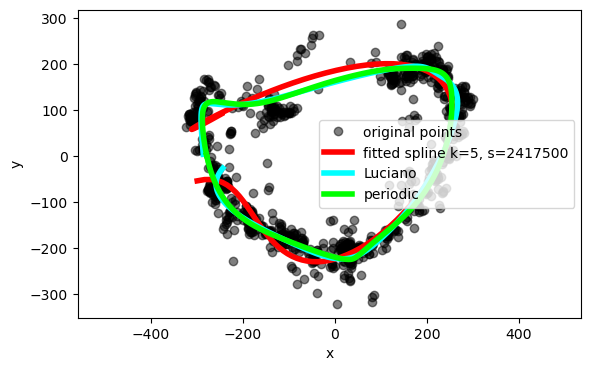

fov_8_spor_pick_23_ring_0_rot_xy_update.hdf5
angle -179.2974853515625 178.69158935546875
[[-122.21399   -123.57727   -114.60852   ... -123.93665   -137.1671
  -118.62023  ]
 [  -1.4985487   -9.31507    -13.153548  ...    4.954621     4.215545
     2.709297 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3671488>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB838A588>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][601]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][601]=x[1][0]
  (i, m, i)))


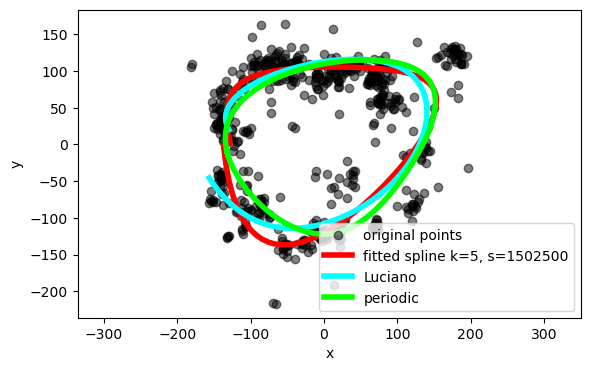

fov_8_spor_pick_24_ring_0_rot_xy_update.hdf5
angle -175.88621520996094 179.44903564453125
[[-408.78445   -243.29617   -325.53836   ... -360.4407    -367.3079
  -358.85083  ]
 [ -29.40093    -66.419846  -107.24596   ...   11.994667    11.859373
     3.4508336]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB838F348>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB8378A88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][560]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][560]=x[1][0]
  (i, m, i)))


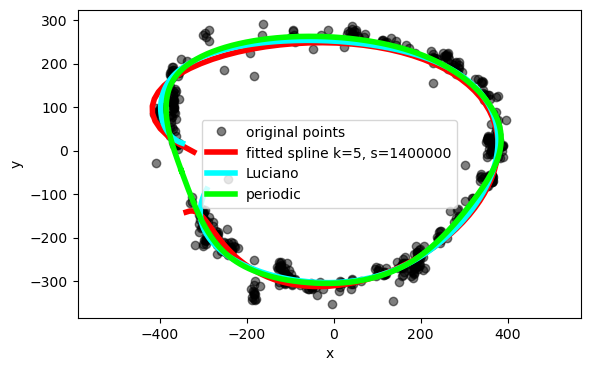

fov_8_spor_pick_25_ring_0_rot_xy_update.hdf5
angle -179.31808471679688 177.67730712890625
[[-193.00455   -183.49673   -111.75064   ... -172.6608    -187.84047
  -185.37563  ]
 [  -2.2971578  -11.892441    -7.3305197 ...   14.470393     8.628077
     7.519007 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE3831CC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB80C0D88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][690]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][690]=x[1][0]
  (i, m, i)))


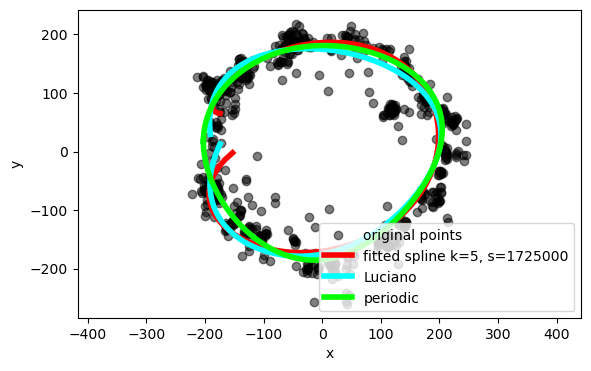

fov_8_spor_pick_26_ring_0_rot_xy_update.hdf5
angle -179.89910888671875 179.6913299560547
[[-312.12814    -315.26486    -323.68674    ... -317.7805
  -314.42108    -323.44455   ]
 [  -0.54961836   -0.59310013   -1.4683511  ...    2.338873
     1.9770197     1.7424834 ]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB8107D48>, <scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB838F608>]


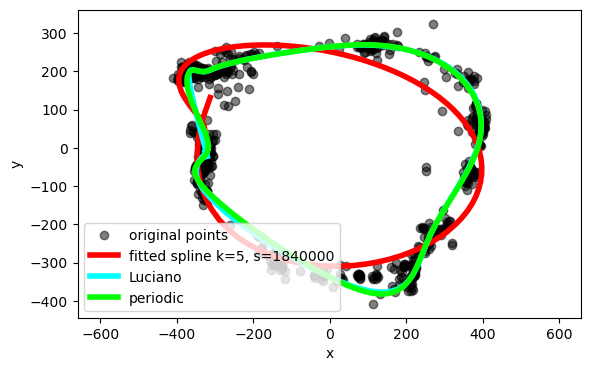

fov_8_spor_pick_27_ring_0_rot_xy_update.hdf5
angle -179.46536254882812 179.90350341796875
[[-306.96713    -324.2249     -320.72885    ... -330.93198
  -311.639      -381.64682   ]
 [  -2.8644361    -5.4861007    -5.814908   ...    1.5963738
     1.264426      0.64273256]]
[<scipy.interpolate.fitpack2.UnivariateSpline object at 0x000000CBB808F308>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7E513C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1453]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1453]=x[1][0]
  (i, m, i)))


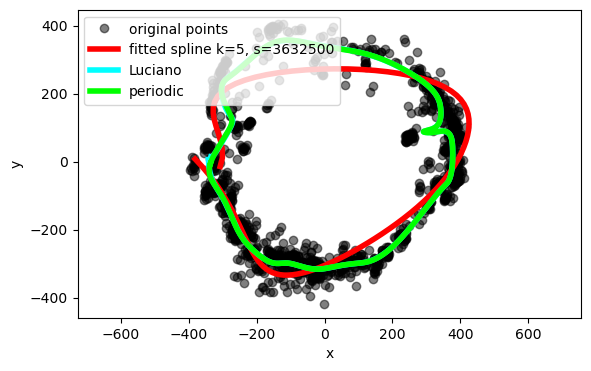

fov_8_spor_pick_28_ring_0_rot_xy_update.hdf5
angle -173.0189208984375 179.95811462402344
[[-3.2560886e+02 -3.2577289e+02 -3.2068698e+02 ... -3.6604639e+02
  -3.6610104e+02 -3.5930026e+02]
 [-3.9870583e+01 -6.2192074e+01 -6.3275063e+01 ...  2.7396578e+01
   5.8685737e+00  2.6261401e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF743C88>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBE36C2248>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][684]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][684]=x[1][0]
  (i, m, i)))


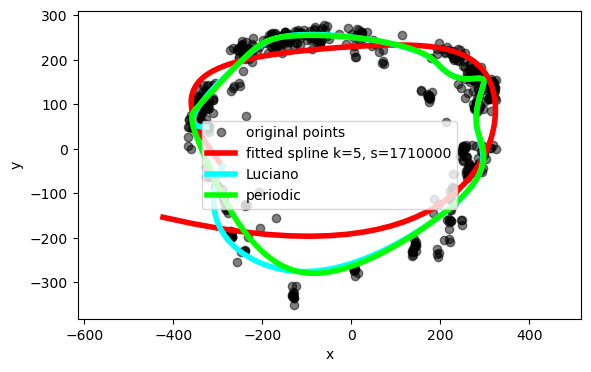

fov_8_spor_pick_29_ring_0_rot_xy_update.hdf5
fov_8_spor_pick_30_ring_0_rot_xy_update.hdf5
angle -179.6884765625 179.79904174804688
[[-368.89676   -355.42026   -372.16238   ... -367.12726   -370.3265
  -364.57648  ]
 [  -2.0057292   -2.7504754   -3.558255  ...    2.7531867    1.7616854
     1.2786801]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7F0AEC8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EC8C88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1234]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1234]=x[1][0]
  (i, m, i)))


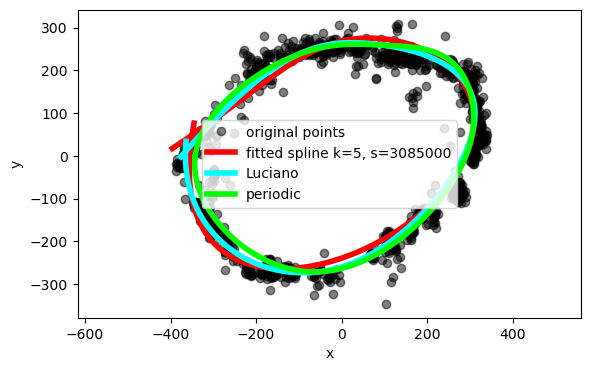

fov_8_spor_pick_31_ring_0_rot_xy_update.hdf5
angle -179.66416931152344 179.9652862548828
[[-3.3913889e+02 -3.2093188e+02 -3.3854904e+02 ... -3.3515842e+02
  -3.4197482e+02 -3.3658420e+02]
 [-1.9878627e+00 -2.3981848e+00 -3.0689721e+00 ...  1.3658456e+00
   3.7738723e-01  2.0396082e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C23588>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7D891C8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][943]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][943]=x[1][0]
  (i, m, i)))


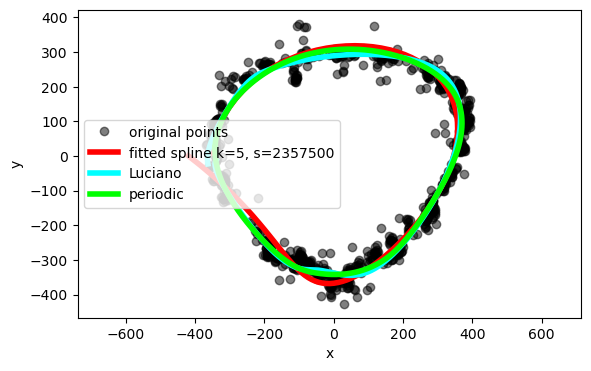

fov_5_veg_pick_0_ring_0_rot_xy_update.hdf5
angle -179.87847900390625 178.39524841308594
[[-256.9629    -263.43164   -273.41208   ... -369.63477   -261.17773
  -256.36523  ]
 [  -0.5449894   -2.18659     -6.6563134 ...   17.283215     8.2762
     7.18219  ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EF3648>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB7EF3E48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][902]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][902]=x[1][0]
  (i, m, i)))


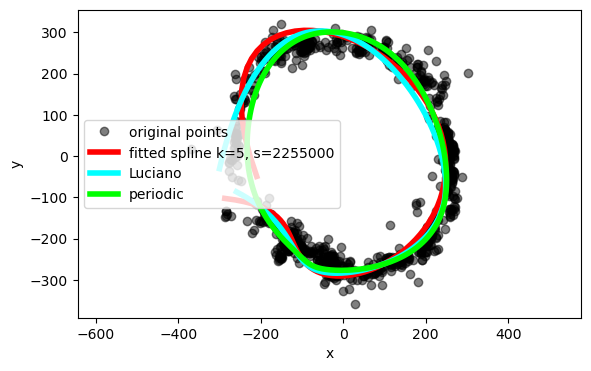

fov_5_veg_pick_1_ring_0_rot_xy_update.hdf5
angle -179.90213012695312 179.631103515625
[[-323.75665   -344.45197   -320.38165   ... -325.45587   -336.82306
  -364.8699   ]
 [  -0.5529585  -10.26445    -12.023944  ...    5.5316114    4.003518
     2.3492131]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAFA37188>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1D44E88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][911]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][911]=x[1][0]
  (i, m, i)))


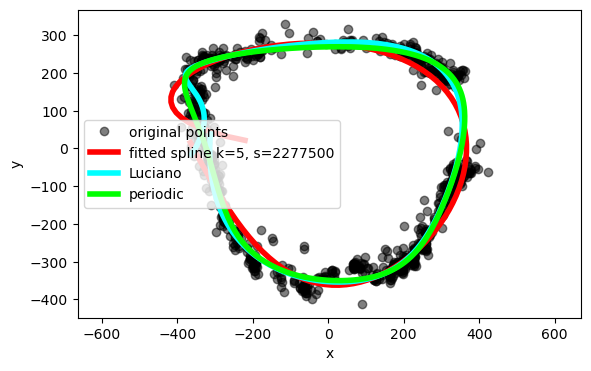

fov_5_veg_pick_2_ring_0_rot_xy_update.hdf5
angle -179.88211059570312 179.9755401611328
[[-3.4225659e+02 -2.3970581e+02 -3.5789331e+02 ... -3.4328000e+02
  -3.4425659e+02 -3.5018237e+02]
 [-7.0418197e-01 -1.1469376e+00 -5.4358921e+00 ...  1.3597388e+00
   1.1755657e+00  1.4949995e-01]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF8AB348>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1B30EC8>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1004]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1004]=x[1][0]
  (i, m, i)))


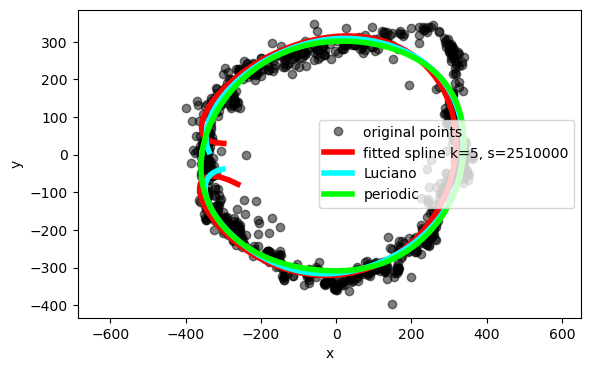

fov_5_veg_pick_3_ring_0_rot_xy_update.hdf5
angle -179.76284790039062 179.8626251220703
[[-212.48137    -231.36029    -241.81343    ... -250.53218
  -246.8798     -218.7392    ]
 [  -0.87943554   -4.025399     -5.526905   ...    5.9756374
     3.9488108     0.5244173 ]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBAF9D08C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C9BE88>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][843]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][843]=x[1][0]
  (i, m, i)))


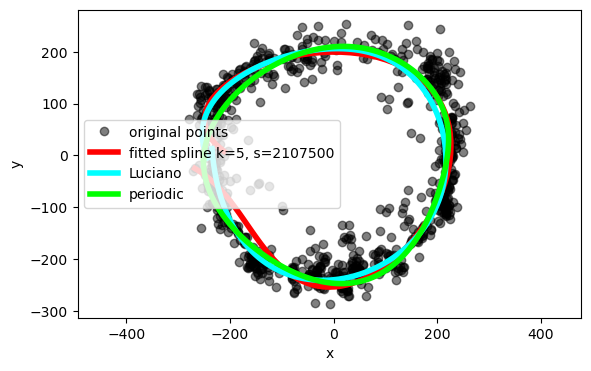

fov_5_veg_pick_4_ring_0_rot_xy_update.hdf5
angle -179.24444580078125 179.72225952148438
[[-229.36713   -249.66791   -214.76555   ... -222.79681   -225.15619
  -259.95697  ]
 [  -3.0248039   -5.5908895   -6.0147576 ...    1.6322472    1.3863205
     1.2601354]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB81FAE88>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB838CC08>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][924]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][924]=x[1][0]
  (i, m, i)))


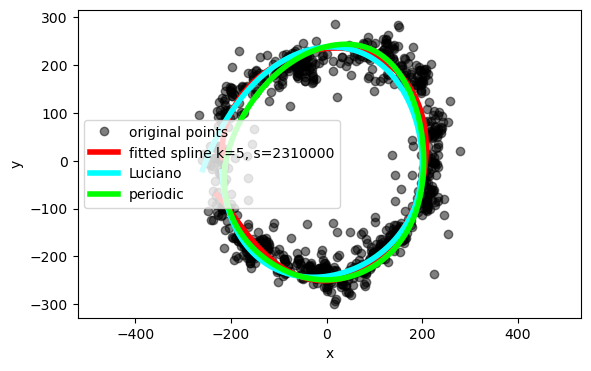

fov_5_veg_pick_5_ring_0_rot_xy_update.hdf5
angle -178.73362731933594 179.74302673339844
[[-151.9148     -196.21558    -178.55542    ... -151.09839
  -183.51247    -201.75073   ]
 [  -3.3582084   -21.872942    -22.362967   ...    3.8029764
     1.1888949     0.90486676]]
[<scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1B830C8>, <scipy.interpolate.fitpack2.LSQUnivariateSpline object at 0x000000CBB1C9BC48>]


W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][622]=x[0][0]
  (i, m, i)))
W:\users\reinhardt\z.software\PythonEnvironment\envs\exp_img_SR\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][622]=x[1][0]
  (i, m, i)))


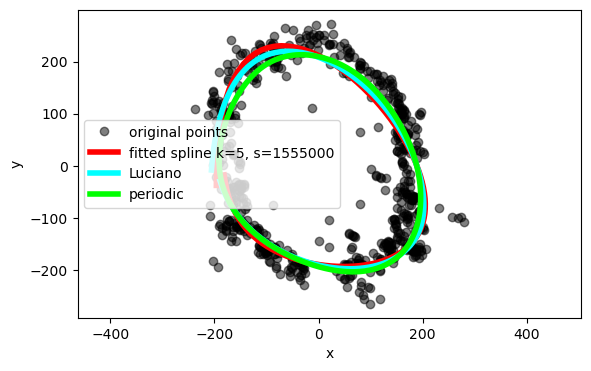

In [ ]:

orientation = 'xy' # use yz, but also xy files contain info for filtering

"""
cipy.interpolate.CubicSpline [link]: Does natural (cubic) spline fitting. Does interpolation, and there is no way to smooth the data.

scipy.interpolate.UnivariateSpline [link]: Does spline fitting with user selectable smoothing factor. However, there is no option to make the splines natural.
"""


df_ring_data['filename_ring'] =  'fov_' + df_ring_data['fov_id'].astype(str) +'_' + df_ring_data['cell_type'].astype(str) +'_pick_' + df_ring_data['group'].astype(str) +'_ring_' + '0' +'_rot_' + orientation + '_update.hdf5'
for index, ring in df_ring_data.iterrows():
    
    radius_fit = ring['radius']
    radius_min = radius_fit - dR
    radius_max = radius_fit + dR
    
    
    plt.close('all')
    locs, info, pixelsize = load_data(os.path.join(path, 'analysis', 'ring_locs', ring['filename_ring'] ))
    print(ring['filename_ring'])

    if ring['filter_passed'] == 'No':
        continue
        
    df_locs = pd.DataFrame.from_records(locs)
    
    # filter
    df_locs = df_locs[(df_locs['radius']>radius_min) & (df_locs['radius']<radius_max)]
    
    df_locs = df_locs.sort_values(by='angle')
    print('angle', df_locs['angle'].min(), df_locs['angle'].max(), )
    
    
        
    """
    x = locs['x']
    y = locs['y']
    
    points = np.array([x,y]).T
    
    
    # Define some points:
    theta = np.linspace(-3, 2, 40)
    points = np.vstack( (np.cos(theta), np.sin(theta)) ).T

    # add some noise:
    points = points + 0.05*np.random.randn(*points.shape)
    """
    
    
    theta = df_locs['angle']/180*np.pi
    R = df_locs['radius']
    
    x = R * np.cos(theta)
    y = R * np.sin(theta)
    
    
    
    points = np.vstack( (x, y) ).T
    k = 5
    m = len(df_locs)
    #s = (m-np.sqrt(2*m)) * 50**2
    s = m * 50**2
    # s=3
    
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    print(points.T)
    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=k, s=s) for coords in points.T]
    print(splines)
    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, 100) #2*np.pi
    points_fitted = np.vstack( spl(alpha) for spl in splines ).T

    # Graph:
    linewidth = 4
    fig, ax = plt.subplots(figsize=(6.5, 4))

    ax.plot(*points.T, 'ok', label='original points', alpha = 0.5);
    ax.plot(*points_fitted.T, '-r', label='fitted spline k=' + str(k) + ', s=' + str(s), linewidth = linewidth);
    ax.axis('equal'); plt.xlabel('x'); plt.ylabel('y');
    #plt.xlim(-10,10)
    
    """
    splines_smooth = [spl.set_smoothing_factor(0.5) for spl in splines]
    print(splines_smooth)
    print(type(splines_smooth))
    points_fitted_smooth = np.vstack( spl(alpha) for spl in splines_smooth ).T
    plt.plot(*points_fitted_smooth.T, '-r', label='fitted spline k=3, s=.2 smooth');
    """
    
    
    
    # 2nd approach
    
    
    
    def interpol3D(num_true_pts, s, x_array, y_array, z_array, per = 0):
    
        tck, u = interpolate.splprep([x_array, y_array, z_array], s=s, per = per) # adding per = 1 fixed it
        x_knots, y_knots, z_knots = interpolate.splev(tck[0], tck)
        u_fine = np.linspace(0, 1, num_true_pts)
        x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

        return x_fine, y_fine, z_fine
    
    # interpolation parameters ###
    num_true_pts = m
    s = s/2
    
    x_fine, y_fine, z_fine, = interpol3D(num_true_pts, s, x, y, np.zeros(len(x)))

    ax.plot(x_fine, y_fine, color = 'cyan', label = 'Luciano', linewidth = linewidth)
    
    x_fine, y_fine, z_fine, = interpol3D(num_true_pts, s, x, y, np.zeros(len(x)), per = 1)

    ax.plot(x_fine, y_fine, color = 'lime', label = 'periodic', linewidth = linewidth)
    ax.legend()
    ax.axes.set_aspect('equal')


    plt.show()
    
    """
    # 3rd approach
    #theta = 2 * np.pi * np.linspace(0, 1, 5)
    #y = np.c_[np.cos(theta), np.sin(theta)]

    theta_np = np.array(theta) 

    theta_np = np.append(theta_np, theta_np[0]+2*np.pi) # add first value. But because array needs to be increasing add 2pi

    y = np.c_[R * np.cos(theta), R * np.sin(theta)]
    y = np.append(y,[y[0]], axis = 0)

    cs = CubicSpline(theta_np, y, bc_type='periodic', axis=0)
    xs = 2 * np.pi * np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6.5, 4))

    ax.plot(y[:, 0], y[:, 1], 'o', label='data')
    ax.plot(np.cos(xs), np.sin(xs), label='true')
    ax.plot(cs(xs)[:, 0], cs(xs)[:, 1], label='spline')
    ax.axes.set_aspect('equal')
    plt.show()
    
    
    # 4th appraoch
    knots = 60

    model_R = get_natural_cubic_spline_model(theta, R, minval=min(theta), maxval=max(theta), n_knots=knots)
    #model_y = get_natural_cubic_spline_model(theta, y, minval=min(theta), maxval=max(theta), n_knots=knots)
    
    y_est_R = model_R.predict(R)
    #y_est_y = model_y.predict(y)
    print(y_est_R)
    fig, ax = plt.subplots(figsize=(6.5, 4))

    ax.plot(x, y, 'o', label='original', color = 'black', alpha = 0.5)
    ax.plot(y_est_R *np.cos(theta), y_est_R * np.sin(theta), 'o', label='fit')
    ax.legend()
    ax.axes.set_aspect('equal')
    plt.show()
    """
    
    #break
    
"""
rng = np.random.default_rng()
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * rng.standard_normal(50)
plt.plot(x, y, 'ro', ms=5)

spl = UnivariateSpline(x, y)
xs = np.linspace(-3, 3, 1000)
plt.plot(xs, spl(xs), 'g', lw=3)

spl.set_smoothing_factor(0.5)
plt.plot(xs, spl(xs), 'b', lw=3)
plt.show()
"""

In [10]:
plt.show()